# Створення нейронної мережі

У цьому завданні ми створимо повнозв'язну нейронну мережу, використовуючи при цьому низькорівневі механізми tensorflow.

Архітектура нейромережі представлена на наступному малюнку. Як бачиш, у ній є один вхідний шар, два приховані, а також вихідний шар. В якості активаційної функції у прихованих шарах буде використовуватись сигмоїда. На вихідному шарі ми використовуємо softmax.

Частина коду зі створення мережі вже написана, тобі потрібно заповнити пропуски у вказаних місцях.

## Архітектура нейронної мережі

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Про датасет MNIST

Дану нейромережу ми будемо вивчати на датасеті MNIST. Цей датасет являє собою велику кількість зображень рукописних цифр розміром $28 \times 28$ пікселів. Кожен піксель приймає значення від 0 до 255.

Як і раніше, датасет буде розділений на навчальну та тестову вибірки. При цьому ми виконаємо нормалізацію всіх зображень, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.

Окрім того, архітектура нейронної мережі очікує на вхід вектор. У нашому ж випадку кожен об'єкт вибірки являє собою матрицю. Що ж робити? У цьому завданні ми "розтягнемо" матрицю $28 \times 28$, отримавши при цьому вектор, що складається з 784 елементів.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Більше інформації про датасет можна знайти [тут](http://yann.lecun.com/exdb/mnist/).

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras as K
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28 * 28 = 784

learning_rate = 0.001 # швидкість навчання нейронної мережі
training_steps = 3000 # максимальне число епох
batch_size = 256 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
display_step = 100 # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності

n_hidden_1 = 128 # кількість нейронів 1-го шару
n_hidden_2 = 256 # кількість нейронів 2-го шару

In [3]:
# from tensorflow.keras.datasets import mnist
from keras.datasets import mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворюємо матриці розміром 28x28 пікселів у вектор з 784 елементів
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

11490434/11490434 [==============================] - 0s 0us/step


In [4]:
# Створимо нейронну мережу

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)

class NN(tf.Module):
    def __init__(self, name=None):
        super().__init__(name=name)
        # Перший шар, який складається з 128 нейронів
        self.layer1 = DenseLayer(num_features, n_hidden_1, name='layer1')
        # Другий шар, який складається з 256 нейронів
        self.layer2 = DenseLayer(n_hidden_1, n_hidden_2, name='layer2')
        # Вихідний шар
        self.out_layer = DenseLayer(n_hidden_2, num_classes, name='out_layer')


    def __call__(self, x):
        # Передача даних через перші два шари та вихідний шар з функцією активації softmax
        x = self.layer1(x, activation=0)
        x = self.layer2(x, activation=0)
        x = self.out_layer(x, activation=1)

        return x

In [5]:
# В якості функції помилки в даному випадку зручно взяти крос-ентропію
def cross_entropy(y_pred, y_true):
    # Закодувати етикетку в один гарячий вектор.
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Значення передбачення кліпу, щоб уникнути помилки log(0).
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Обчислення крос-ентропії
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# Як метрику якості використовуємо точність
def accuracy(y_pred, y_true):
    # Порівнюємо передбачені значення з істинними мітками
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    # Обчислюємо середню точність з використанням згортання
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [6]:
# Створимо екземпляр нейронної мережі
neural_net = NN(name="mnist")

# Функція навчання нейромережі
def train(neural_net, input_x, output_y):
  # Для налаштування вагів мережі будемо використовувати стохастичний градієнтний спуск
  optimizer = tf.optimizers.SGD(learning_rate)

  # Активація автоматичного диференціювання
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)

    # Отримаємо список оптимізованих параметрів
    trainable_variables = neural_net.trainable_variables

    # Обчислимо за ними значення градієнта
    gradients = g.gradient(loss, trainable_variables)

    # Модифікуємо параметри
    optimizer.apply_gradients(zip(gradients, trainable_variables))

In [7]:
# Тренування мережі

loss_history = []  # кожні display_step кроків зберігай в цьому списку поточну помилку нейромережі
accuracy_history = [] # кожні display_step кроків зберігай в цьому списку поточну точність нейромережі

# У цьому циклі ми будемо проводити навчання нейронної мережі
# із тренувального датасета train_data вилучи випадкову підмножину, на якій
# відбудеться тренування. Використовуй метод take, доступний для тренувального датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Оновлюємо ваги нейронної мережі
    train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        pred = neural_net(batch_x)
        loss = cross_entropy(pred, batch_y)
        acc = accuracy(pred, batch_y)
        loss_history.append(loss)
        accuracy_history.append(acc)
        print(f"Крок: {step}, Функція втрат: {loss}, Точність: {acc}")

Крок: 100, Функція втрат: 373.4165344238281, Точність: 0.671875
Крок: 200, Функція втрат: 221.02978515625, Точність: 0.76953125
Крок: 300, Функція втрат: 205.47869873046875, Точність: 0.75
Крок: 400, Функція втрат: 136.5055694580078, Точність: 0.8203125
Крок: 500, Функція втрат: 132.51446533203125, Точність: 0.85546875
Крок: 600, Функція втрат: 114.43498229980469, Точність: 0.86328125
Крок: 700, Функція втрат: 135.64173889160156, Точність: 0.8359375
Крок: 800, Функція втрат: 107.77426147460938, Точність: 0.859375
Крок: 900, Функція втрат: 81.27095031738281, Точність: 0.890625
Крок: 1000, Функція втрат: 99.28294372558594, Точність: 0.87890625
Крок: 1100, Функція втрат: 104.83238983154297, Точність: 0.8671875
Крок: 1200, Функція втрат: 86.38065338134766, Точність: 0.89453125
Крок: 1300, Функція втрат: 98.4160385131836, Точність: 0.8984375
Крок: 1400, Функція втрат: 69.59254455566406, Точність: 0.921875
Крок: 1500, Функція втрат: 114.31895446777344, Точність: 0.8671875
Крок: 1600, Функція

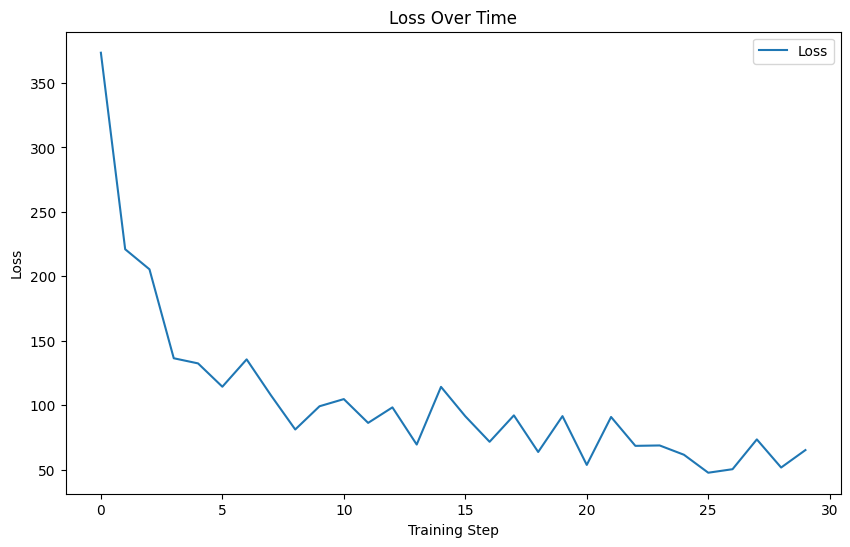

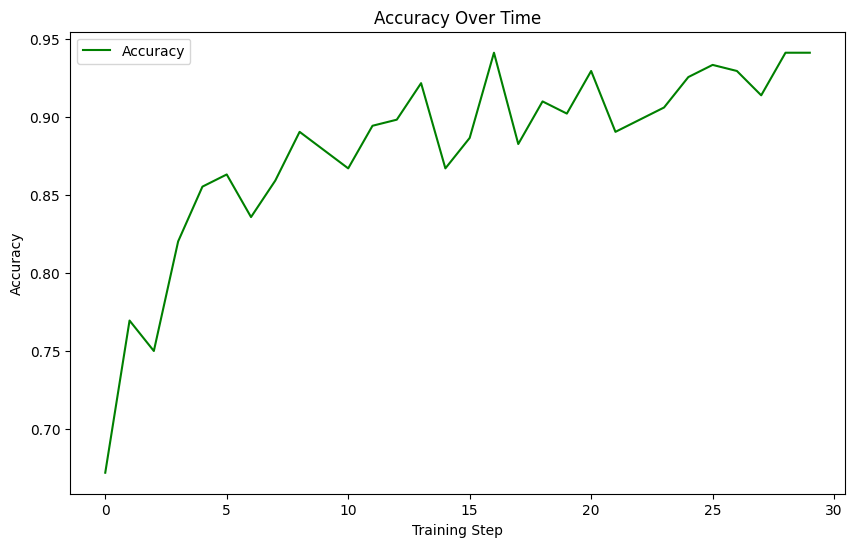

In [8]:
# Виведи графіки залежності зміни точності і втрат від кроку
# Якщо все зроблено правильно, то точність повинна зростати, а втрати зменшуватись

import matplotlib.pyplot as plt

# Виведіть графік функції втрат
plt.figure(figsize=(10, 6))
plt.plot(loss_history, label='Loss')
plt.title('Loss Over Time')
plt.xlabel('Training Step')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Виведіть графік точності
plt.figure(figsize=(10, 6))
plt.plot(accuracy_history, label='Accuracy', color='green')
plt.title('Accuracy Over Time')
plt.xlabel('Training Step')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [9]:
# Обчисли точність навченої нейромережі

# Тестування моделі на тестових даних
# Обчисліть точність навченої нейромережі
# Місце для вашого коду
train_pred = neural_net(x_train)
train_accuracy = accuracy(train_pred, y_train)

print(f"Training accuracy: {train_accuracy}")
test_pred = neural_net(x_test)
test_accuracy = accuracy(test_pred, y_test)

print(f"Test accuracy: {test_accuracy}")

Training accuracy: 0.9219333529472351
Test accuracy: 0.902899980545044


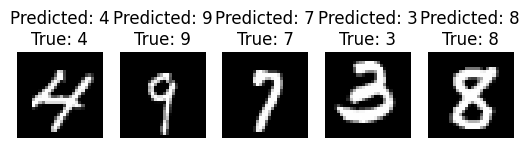

In [10]:
# Протестуємо навчену нейромережу на 10 зображеннях. З тестової вибірки візьми 5
# випадкових зображень і передай їх у нейронну мережу.
# Виведи зображення та випиши поруч відповідь нейромережі.
# Зроби висновок про те, чи помиляється твоя нейронна мережа, і якщо так, то як часто?

num_images = 5
random_indices = np.random.choice(x_test.shape[0], num_images)
sample_images = x_test[random_indices]
sample_labels = y_test[random_indices]

# Отримання передбачень від моделі
predictions = neural_net(sample_images)

# Візуалізація результатів
for i in range(num_images):
    plt.subplot(1, num_images, i+1)
    plt.imshow(np.reshape(sample_images[i], [28, 28]), cmap='gray')
    plt.title(f'Predicted: {np.argmax(predictions[i])}\nTrue: {sample_labels[i]}')
    plt.axis('off')

plt.show()

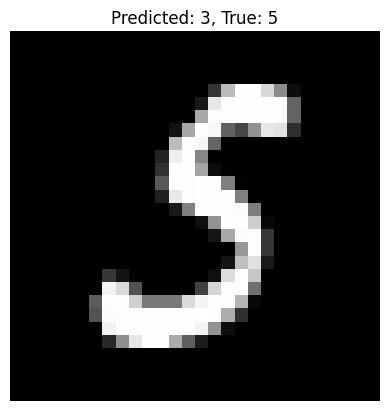

In [13]:
num_images = 10  # змініть на кількість зображень, яку хочете перевірити
random_indices = np.random.choice(x_test.shape[0], num_images)
sample_images = x_test[random_indices]
sample_labels = y_test[random_indices]

# Отримання передбачень від моделі
predictions = neural_net(sample_images)

# Аналіз помилок моделі
misclassified_indices = [i for i in range(num_images) if np.argmax(predictions[i]) != sample_labels[i]]

# Візуалізація неправильних передбачень
for i in misclassified_indices:
    plt.imshow(np.reshape(sample_images[i], [28, 28]), cmap='gray')
    plt.title(f'Predicted: {np.argmax(predictions[i])}, True: {sample_labels[i]}')
    plt.axis('off')
    plt.show()

# **Висновок**
Наша модель показала дуже добрі результати:

Training accuracy: 0.9219333529472351

Test accuracy: 0.902899980545044

Що свідчить про велику точність та здатність моделі добре узагальнювати нові дані.